In [2]:
pwd

/scratch/t.cri.ksilliman/CommonG/2019_Mapping/ANGSD_run/HCSS/GWAS


# LFMM method  
https://bcm-uga.github.io/lfmm/articles/lfmm  
The R package lfmm implements new algorithms for parameter estimation in latent factor mixed models (LFMM). The algorithms are designed for the correction of unobserved confounders. The new methods are computationally efficient, and provide statistically optimal corrections resulting in improved power and control for false discoveries.

# Formatting phenotype data

In [90]:
library(stringr)
library(tidyverse)
library(lfmm)

In [228]:
intable <- read.csv("Common Garden DNA Samples - Adult oysters.csv",
                   )[,c(1,3,4,12,13)]

In [229]:
head(intable)

Population,Family,Size,Wet.weight..g.,Width..mm.
Oyster Bay,1,1A,3.6,32.62
Oyster Bay,1,1B,3.6,32.62
Oyster Bay,1,2,1.5,23.10
Oyster Bay,1,3,5.0,NA
Oyster Bay,1,4,5.3,NA
Oyster Bay,1,5,4.5,27.25


In [230]:
intable$Population <- c("SS","HC","NF",intable$Population)[match(intable$Population, c("Oyster Bay","Hood Canal","Fidalgo Bay",intable$Population))]

In [231]:
intable$id <- paste(paste0(intable$Population, intable$Family), gsub("[^0-9]","",intable$Size), sep="-")

In [232]:
intable <- intable[,c(4,5,6)]
head(intable)

Wet.weight..g.,Width..mm.,id
3.6,32.62,SS1-1
3.6,32.62,SS1-1
1.5,23.10,SS1-2
5.0,NA,SS1-3
5.3,NA,SS1-4
4.5,27.25,SS1-5


In [233]:
inds = as.vector(read.table("../SSHCbams_filt_nreps",header = F))
inds <- inds[,1]
inds <- gsub("\\..*","",inds)
inds <- str_remove(inds,"-L5")
inds <- gsub("[A-Z]$?","",inds)
head(inds)
length(inds)
inds

[1] "HC1-11" "HC1-12" "HC1-13" "HC1-14" "HC1-15" "HC1-18"

[1] 114

[1] "HC1-11" "HC1-12" "HC1-13" "HC1-14" "HC1-15" "HC1-18" "HC1-19" "HC1-2" 
  [9] "HC1-3"  "HC1-4"  "HC1-9"  "HC2-1"  "HC2-10" "HC2-11" "HC2-12" "HC2-13"
 [17] "HC2-14" "HC2-15" "HC2-16" "HC2-17" "HC2-18" "HC2-19" "HC2-2"  "HC2-20"
 [25] "HC2-3"  "HC2-4"  "HC2-5"  "HC2-7"  "HC2-9"  "HC3-1"  "HC3-10" "HC3-11"
 [33] "HC3-12" "HC3-13" "HC3-14" "HC3-16" "HC3-18" "HC3-2"  "HC3-3"  "HC3-4" 
 [41] "HC3-5"  "HC3-6"  "HC3-7"  "HC3-8"  "HC3-9"  "HC4-17" "HC4-1"  "HC4-2" 
 [49] "HC4-4"  "HC4-5"  "HC4-6"  "HC5-10" "HC5-11" "HC5-14" "HC5-15" "HC5-16"
 [57] "HC5-3"  "SS1-1"  "SS1-10" "SS1-12" "SS1-14" "SS1-17" "SS1-19" "SS1-2" 
 [65] "SS1-20" "SS1-5"  "SS1-6"  "SS1-7"  "SS1-8"  "SS2-10" "SS2-12" "SS2-13"
 [73] "SS2-14" "SS2-15" "SS2-16" "SS2-17" "SS2-18" "SS2-19" "SS2-4"  "SS2-5" 
 [81] "SS2-9"  "SS3-1"  "SS3-11" "SS3-13" "SS3-14" "SS3-15" "SS3-16" "SS3-17"
 [89] "SS3-19" "SS3-2"  "SS3-20" "SS3-3"  "SS3-4"  "SS3-5"  "SS3-6"  "SS3-7" 
 [97] "SS3-8"  "SS3-9"  "SS4-1"  "SS4-4"  "SS5-10" "SS5-11" "SS5-12" "SS5-13"
[105] "SS5-15" "SS5-18" "SS5-19" "SS5-3"  "SS5-4"  "SS5-5"  "SS5-6"  "SS5-7" 
[113] "SS5-8"  "SS5-9"

In [234]:
seqs <- intable[which(intable$id %in% inds),]
seqs <- seqs[!duplicated(seqs$id),]
seqs <- seqs[match(inds, seqs$id),]
seqs[, c(1,2)] <- sapply(seqs[, c(1,2)], as.numeric)
dim(seqs)
head(seqs)

[1] 114   3

,Wet.weight..g.,Width..mm.,id
146,1.9,23.94,HC1-11
147,1.9,18.59,HC1-12
148,1.9,20.83,HC1-13
149,1.6,20.79,HC1-14
150,1.8,19.51,HC1-15
153,1.7,21.97,HC1-18


In [235]:
seqs[is.na(seqs),]

,Wet.weight..g.,Width..mm.,id
154,NA,17.77,HC1-19


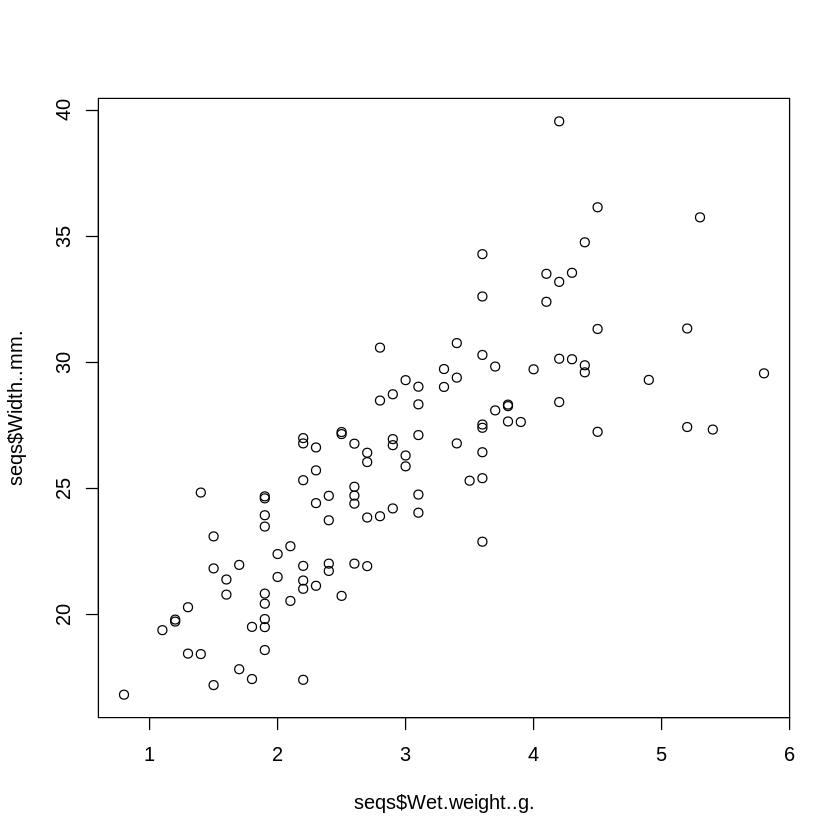

In [236]:
plot(seqs$Wet.weight..g.,seqs$Width..mm.)

# Formatting genotype data  
LFMM requires a matrix with individuals as rows, columns as loci, and 0,1,2 for the # of alleles. Missing genotypes are 9 or -9.  
ANGSD -doGeno 2 makes a matrix with loci as rows, columns as individuals, 0,1,2 and missing genotypes as -1.


In [ ]:
#submitted as job to cluster
FILTERS="-uniqueOnly 1 -remove_bads 1 -minMapQ 20 -minQ 25 -sb_pval 1e-5\
-skipTriallelic 1 -minInd 80 -minIndDepth 3 -snp_pval 1e-3 -minMaf 0.01"

TODOlfmm="-doMajorMinor 1 -doMaf 1 -doCounts 1 -doGeno 2 -doPost 1 \
-doGlf 2 -dosnpstat 1 -postCutoff 0.5"

angsd -b SSHCbams_filt_nreps -GL 1 $FILTERS $TODOlfmm -P 1 -out ../ANGSD_run/HCSS/HCSS_Afilt32m70_01lfmm


In [ ]:
gunzip ../HCSS_Afilt32m70_01lfmm.geno.gz

In [71]:
geno <- read.table("../HCSS_Afilt32m70_01lfmm.geno",header = F)

In [31]:
head(geno)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116
Contig0,109103,1,0,2,0,1,1,0,1,...,0,2,0,1,0,2,0,1,0,0
Contig0,109119,1,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Contig0,109120,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
Contig0,109123,1,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Contig1,42880,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Contig3,14914,0,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1


In [72]:
loci <- paste(geno[,1],geno[,2],sep="_")
rownames(geno) <- loci
geno <- geno[,-c(1,2)]
colnames(geno) <- seqs$id
geno <- t(geno)
geno[geno==-1] <- 9

In [73]:
head(geno)

,Contig0_109103,Contig0_109119,Contig0_109120,Contig0_109123,Contig1_42880,Contig3_14914,Contig4_51093,Contig5_121384,Contig8_75328,Contig9_17749,...,Contig657446_41,Contig657446_47,Contig657446_49,Contig658520_5162,Contig658520_5426,Contig669985_403,Contig671940_250,Contig674034_1460,Contig676684_821,Contig676684_836
HC1-11,1,1,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,1
HC1-12,0,0,0,0,1,0,0,0,0,1,...,1,0,0,1,1,1,0,2,0,0
HC1-13,2,2,0,2,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
HC1-14,0,0,0,0,1,1,0,1,0,1,...,1,0,0,1,1,0,0,0,0,1
HC1-15,1,1,0,1,0,0,1,2,0,1,...,0,0,0,1,1,0,0,0,0,1
HC1-18,1,0,0,0,0,0,0,2,0,1,...,1,1,0,0,1,0,0,0,2,0


In [241]:
seqs <- seqs[-which(seqs$id=="HC1-19"),]
dim(seqs)

[1] 113   3

In [242]:
geno <- geno[!rownames(geno) == "HC1-19",]
dim(geno)

[1]  113 5269

## PCA on genotype data

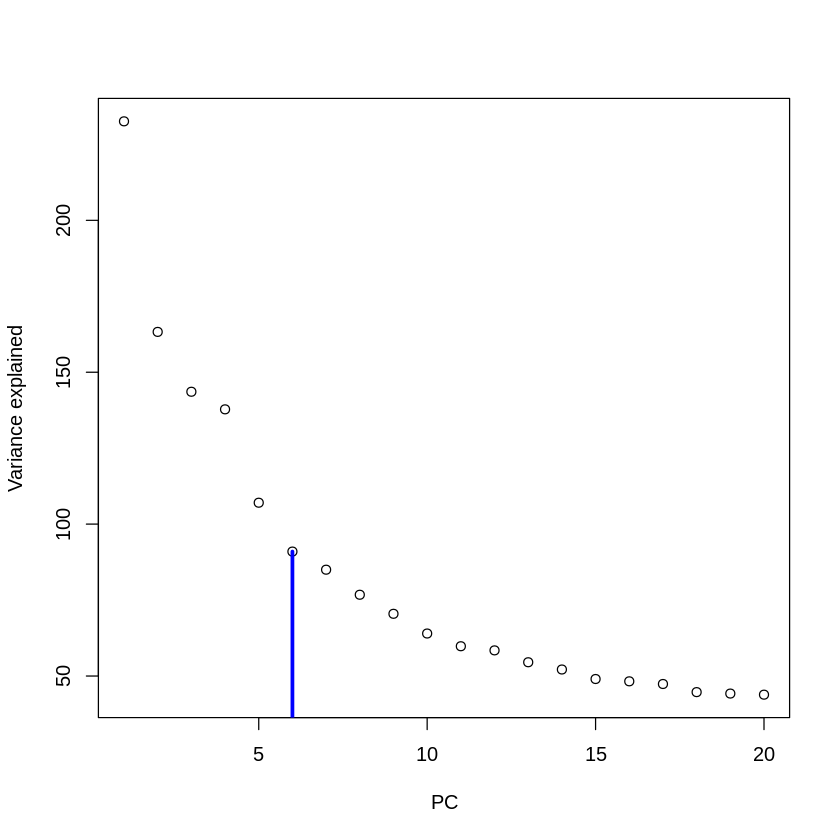

In [245]:
Y <- geno
pc <- prcomp(Y)
plot(pc$sdev[1:20]^2, xlab = 'PC', ylab = "Variance explained")
points(6,pc$sdev[6]^2, type = "h", lwd = 3, col = "blue")

K = 6 components in data, so use K=6 latent factors in model.

# Width
## Ridge estimates and GWAS with lfmm

In [243]:
X <- as.data.frame(seqs$Width..mm.)

In [244]:
colnames(X) <- "Width"
head(X)

Width
23.94
18.59
20.83
20.79
19.51
21.97


In [96]:
?lfmm_test

In [246]:
## Fit an LFMM, i.e, compute B, U, V estimates
mod.lfmm.ridge <- lfmm_ridge(Y = Y, 
                        X = X, 
                        K = 6)

In [247]:
## performs association testing using the fitted model:
 pv_ridge <- lfmm_test(Y = Y, 
                 X = X, 
                 lfmm = mod.lfmm.ridge, 
                 calibrate = "gif")

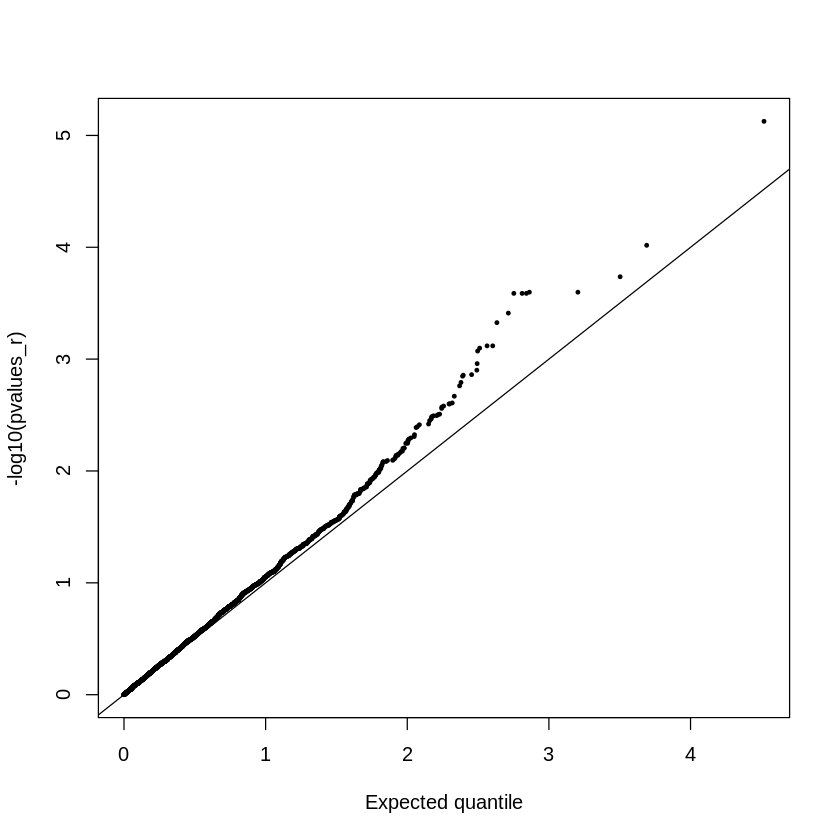

In [248]:
pvalues_r <- pv_ridge$calibrated.pvalue 
qqplot(rexp(length(pvalues_r), rate = log(10)),
       -log10(pvalues_r), xlab = "Expected quantile",
       pch = 19, cex = .4)
abline(0,1)

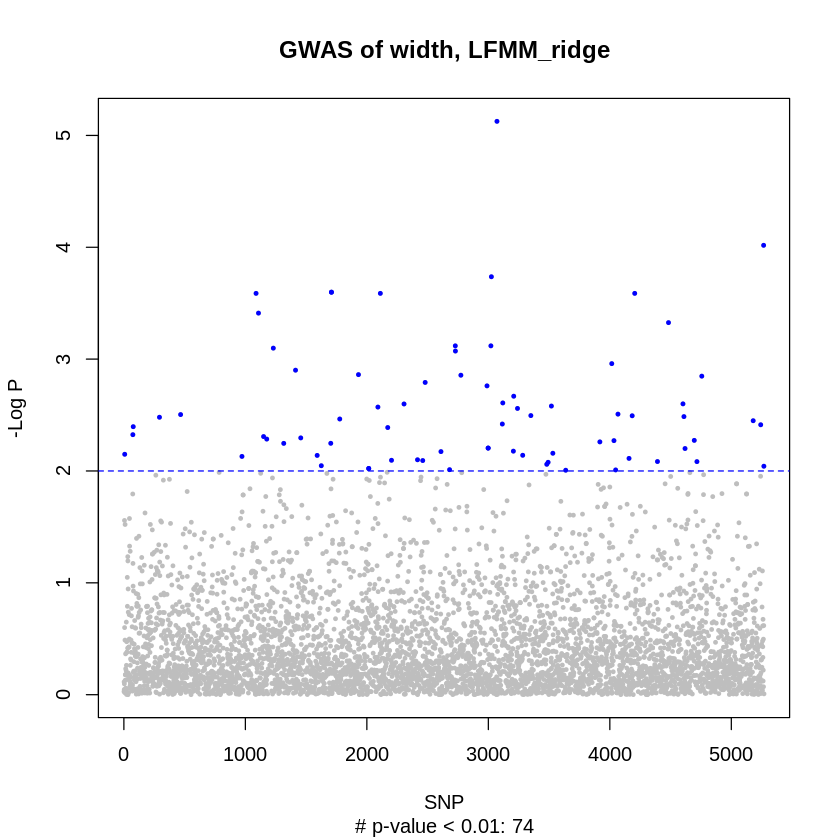

In [249]:
## Manhattan plot
x <- 1:length(pvalues_r)

plot(-log10(pvalues_r), 
      pch = 19, 
      cex = .4, 
      xlab = "SNP", ylab = "-Log P",
      col = "grey")

abline(h=-log10(0.01), col="blue", lty="dashed")
keep <- pvalues_r < 0.01
keep[which(is.na(keep))] <- FALSE
ridgeP01 <- x[keep]
title("GWAS of width, LFMM_ridge",
      sub=paste0("# p-value < 0.01: ",as.character(length(ridgeP01))))
points(ridgeP01,-log10(pvalues_r[keep]), pch=19,cex=.4,col="blue")


In [155]:
pwd

/scratch/t.cri.ksilliman/CommonG/2019_Mapping/ANGSD_run/HCSS/GWAS


In [250]:
write.table(pvalues_r,"GWAS_width_lfmmRidge.pvalues",row.names = T, col.names = T)

## Lasso estimates and GWAS with lfmm
More liberal test

In [251]:
# Fit an LFMM, i.e, compute B, U, V estimates
 mod.lfmm.lasso <- lfmm_lasso(Y = Y, 
                        X = X, 
                        K = 6,
                        nozero.prop = 0.01)

It = 1/100, err2 = 0.643349159118944
It = 2/100, err2 = 0.577648236080479
It = 3/100, err2 = 0.577787402193472
It = 4/100, err2 = 0.577816495679895
It = 5/100, err2 = 0.577819839713709
=== lambda = 0.140940082001527, no zero B proportion = 0.00227747200607326
It = 1/100, err2 = 0.577820259673722
It = 2/100, err2 = 0.577770612587054
It = 3/100, err2 = 0.577764500031541
It = 4/100, err2 = 0.577763717557962
=== lambda = 0.13453413775635, no zero B proportion = 0.00322641867527045
It = 1/100, err2 = 0.577763615370204
It = 2/100, err2 = 0.577708155531622
It = 3/100, err2 = 0.577701581604339
It = 4/100, err2 = 0.577700768664162
=== lambda = 0.128419353563654, no zero B proportion = 0.00322641867527045
It = 1/100, err2 = 0.577700665807883
It = 2/100, err2 = 0.577651170467114
It = 3/100, err2 = 0.577645318097132
It = 4/100, err2 = 0.577644562990186
=== lambda = 0.122582495749696, no zero B proportion = 0.00379578667678876
It = 1/100, err2 = 0.577644459788369
It = 2/100, err2 = 0.57758551486037

In [252]:
## performs association testing using the fitted model:
 pv <- lfmm_test(Y = Y, 
                 X = X, 
                 lfmm = mod.lfmm.lasso, 
                 calibrate = "gif")

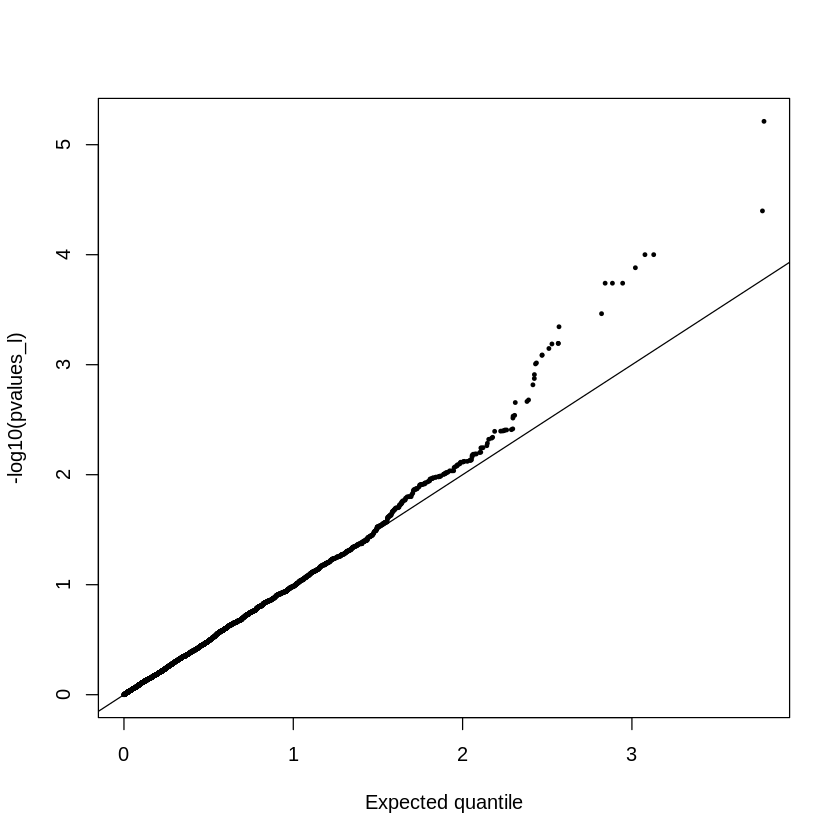

In [253]:
pvalues_l <- pv$calibrated.pvalue 
qqplot(rexp(length(pvalues_l), rate = log(10)),
       -log10(pvalues_l), xlab = "Expected quantile",
       pch = 19, cex = .4)
abline(0,1)

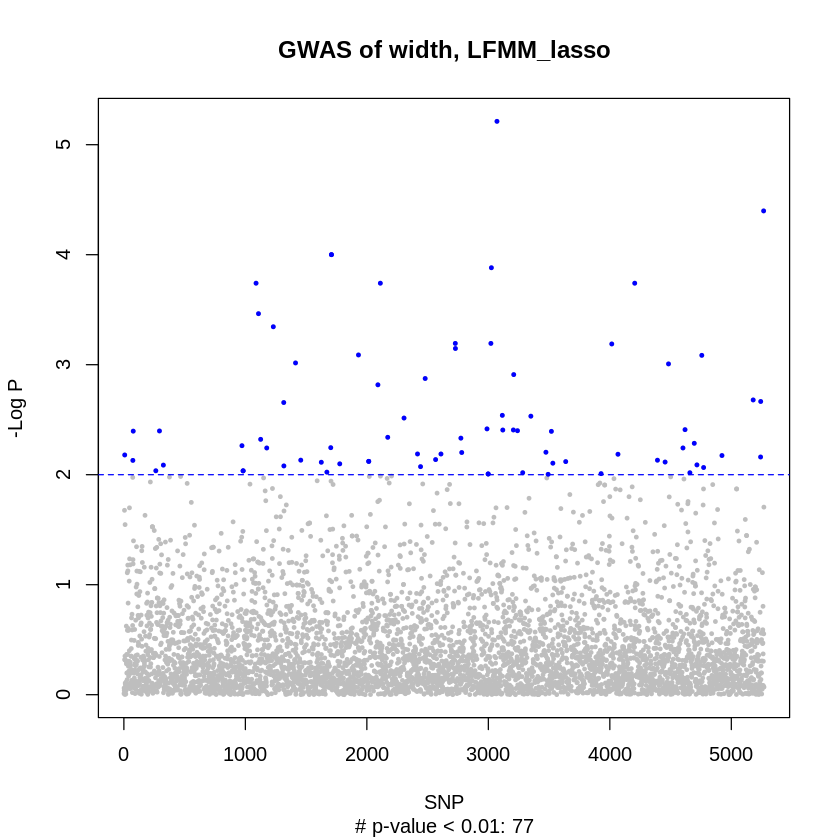

In [254]:
## Manhattan plot
xL <- 1:length(pvalues_l)

plot(-log10(pvalues_l), 
      pch = 19, 
      cex = .4, 
      xlab = "SNP", ylab = "-Log P",
      col = "grey")

abline(h=-log10(0.01), col="blue", lty="dashed")
keep <- pvalues_l < 0.01
keep[which(is.na(keep))] <- FALSE
lassoP01 <- xL[keep]
title("GWAS of width, LFMM_lasso",
      sub=paste0("# p-value < 0.01: ",as.character(length(lassoP01))))
points(lassoP01,-log10(pvalues_l[keep]), pch=19,cex=.4,col="blue")


In [255]:
write.table(pvalues_l,"GWAS_width_lfmmLasso.pvalues",row.names = T, col.names = T)

In [256]:
#SNPs identified by both methods 
both = intersect(rownames(pvalues_l)[lassoP01],rownames(pvalues_r)[ridgeP01])
write.table(both,"GWAS_width_lfmmBothP01.pvalues",row.names = T, col.names = T)
length(both)
both

[1] 60

[1] "Contig4_51093"      "Contig247_19705"    "Contig261_13875"   
 [4] "Contig1752_7704"    "Contig18776_51"     "Contig20301_25778" 
 [7] "Contig20556_1169"   "Contig21828_42443"  "Contig22630_12762" 
[10] "Contig23953_13742"  "Contig25187_18688"  "Contig25811_8609"  
[13] "Contig28385_4082"   "Contig29300_18485"  "Contig29459_8886"  
[16] "Contig29459_8891"   "Contig30657_15625"  "Contig33340_10312" 
[19] "Contig34886_12977"  "Contig34886_12978"  "Contig36003_1403"  
[22] "Contig36326_22771"  "Contig37341_12397"  "Contig39792_8879"  
[25] "Contig42157_9907"   "Contig43024_5264"   "Contig45429_5191"  
[28] "Contig47156_8140"   "Contig47156_8144"   "Contig47842_5739"  
[31] "Contig52538_1318"   "Contig52768_7192"   "Contig52768_7196"  
[34] "Contig53370_3575"   "Contig53438_8766"   "Contig54957_15652" 
[37] "Contig55737_10139"  "Contig55818_10082"  "Contig58197_4188"  
[40] "Contig58213_2334"   "Contig58976_2566"   "Contig60108_2787"  
[43] "Contig61792_3239"   "Contig65363_107"    "Contig65681_10897" 
[46] "Contig65982_869"    "Contig69228_5078"   "Contig83091_64"    
[49] "Contig84975_13331"  "Contig93748_2190"   "Contig104078_662"  
[52] "Contig109827_6152"  "Contig120378_211"   "Contig122227_2746" 
[55] "Contig130869_2254"  "Contig133037_13105" "Contig135601_12809"
[58] "Contig321245_77"    "Contig538871_5542"  "Contig671940_250"

In [257]:
#SNPs identified by at least 1 methods 
un = union(rownames(pvalues_l)[lassoP01],rownames(pvalues_r)[ridgeP01])
write.table(un,"GWAS_width_lfmmUnionP01.pvalues",row.names = T, col.names = T)
length(un)

[1] 91

# Wet.weight

In [258]:
X <- as.data.frame(seqs$Wet.weight..g.)

In [259]:
colnames(X) <- "Wet.weight"
head(X)

Wet.weight
1.9
1.9
1.9
1.6
1.8
1.7


In [96]:
?lfmm_test

In [260]:
## Fit an LFMM, i.e, compute B, U, V estimates
mod.lfmm.ridge <- lfmm_ridge(Y = Y, 
                        X = X, 
                        K = 6)

In [261]:
## performs association testing using the fitted model:
 pv_ridge <- lfmm_test(Y = Y, 
                 X = X, 
                 lfmm = mod.lfmm.ridge, 
                 calibrate = "gif")

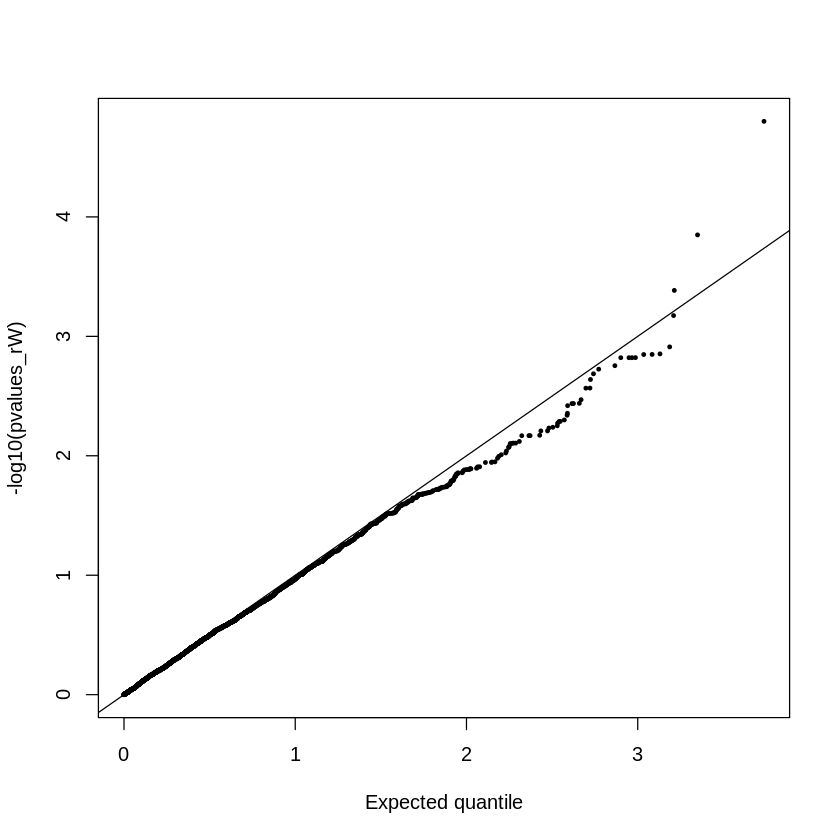

In [262]:
pvalues_rW <- pv_ridge$calibrated.pvalue 
qqplot(rexp(length(pvalues_rW), rate = log(10)),
       -log10(pvalues_rW), xlab = "Expected quantile",
       pch = 19, cex = .4)
abline(0,1)

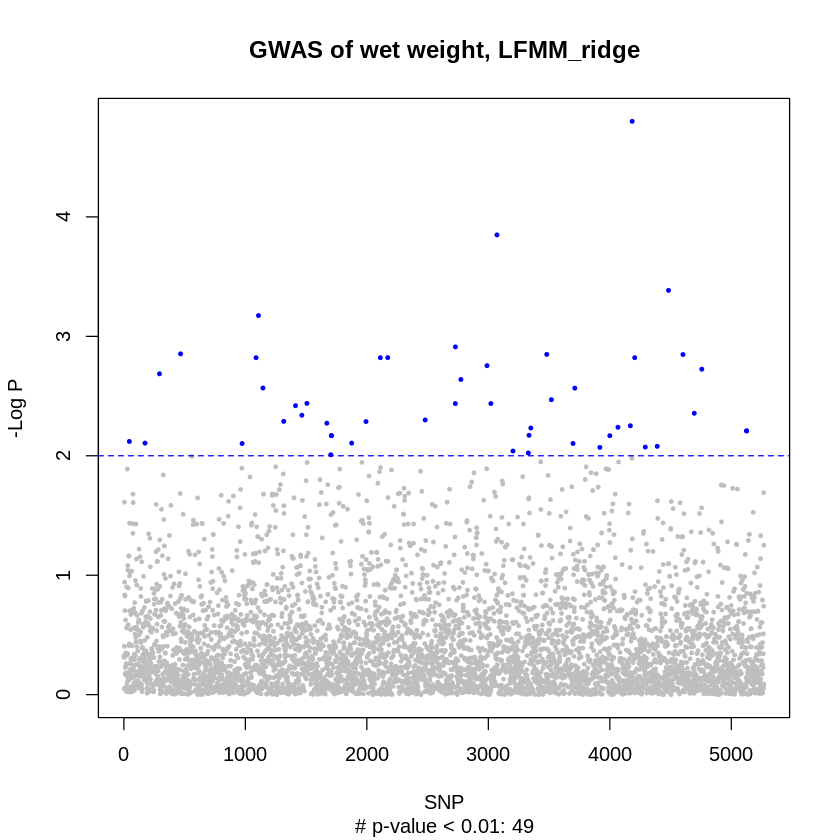

In [264]:
## Manhattan plot
x <- 1:length(pvalues_rW)

plot(-log10(pvalues_rW), 
      pch = 19, 
      cex = .4, 
      xlab = "SNP", ylab = "-Log P",
      col = "grey")

abline(h=-log10(0.01), col="blue", lty="dashed")
keep <- pvalues_rW < 0.01
keep[which(is.na(keep))] <- FALSE
ridgeP01W <- x[keep]
title("GWAS of wet weight, LFMM_ridge",
      sub=paste0("# p-value < 0.01: ",as.character(length(ridgeP01W))))
points(ridgeP01W,-log10(pvalues_rW[keep]), pch=19,cex=.4,col="blue")


In [155]:
pwd

/scratch/t.cri.ksilliman/CommonG/2019_Mapping/ANGSD_run/HCSS/GWAS


In [158]:
write.table(pvalues_r,"GWAS_weight_lfmmRidge.pvalues",row.names = T, col.names = T)

# Lasso estimates and GWAS with lfmm
More liberal test

In [265]:
# Fit an LFMM, i.e, compute B, U, V estimates
 mod.lfmm.lasso <- lfmm_lasso(Y = Y, 
                        X = X, 
                        K = 6,
                        nozero.prop = 0.01)

It = 1/100, err2 = 0.643349159118944
It = 2/100, err2 = 0.577328245387769
It = 3/100, err2 = 0.577410294583587
It = 4/100, err2 = 0.577453161506988
It = 5/100, err2 = 0.57746149480378
It = 6/100, err2 = 0.577462999002511
=== lambda = 0.502099098720345, no zero B proportion = 0.00702220535205921
It = 1/100, err2 = 0.577463265025642
It = 2/100, err2 = 0.577379385257812
It = 3/100, err2 = 0.57736783029336
It = 4/100, err2 = 0.577366125497997
=== lambda = 0.479277919774803, no zero B proportion = 0.00721199468589865
It = 1/100, err2 = 0.577365861380875
It = 2/100, err2 = 0.577283892797508
It = 3/100, err2 = 0.577272678484586
It = 4/100, err2 = 0.57727099387642
=== lambda = 0.457493998633132, no zero B proportion = 0.00816094135509584
It = 1/100, err2 = 0.577270723233401
It = 2/100, err2 = 0.577189804118896
It = 3/100, err2 = 0.577178609374099
It = 4/100, err2 = 0.577176906871591
=== lambda = 0.436700190327308, no zero B proportion = 0.00929967735813247
It = 1/100, err2 = 0.577176630465924


In [266]:
## performs association testing using the fitted model:
 pv <- lfmm_test(Y = Y, 
                 X = X, 
                 lfmm = mod.lfmm.lasso, 
                 calibrate = "gif")

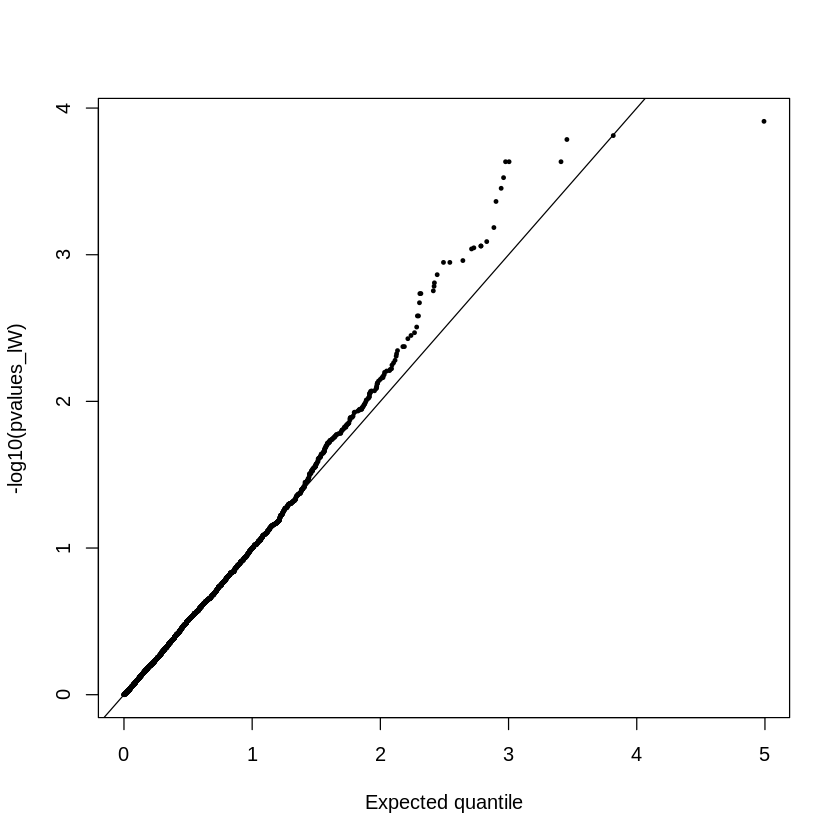

In [267]:
pvalues_lW <- pv$calibrated.pvalue 
qqplot(rexp(length(pvalues_lW), rate = log(10)),
       -log10(pvalues_lW), xlab = "Expected quantile",
       pch = 19, cex = .4)
abline(0,1)

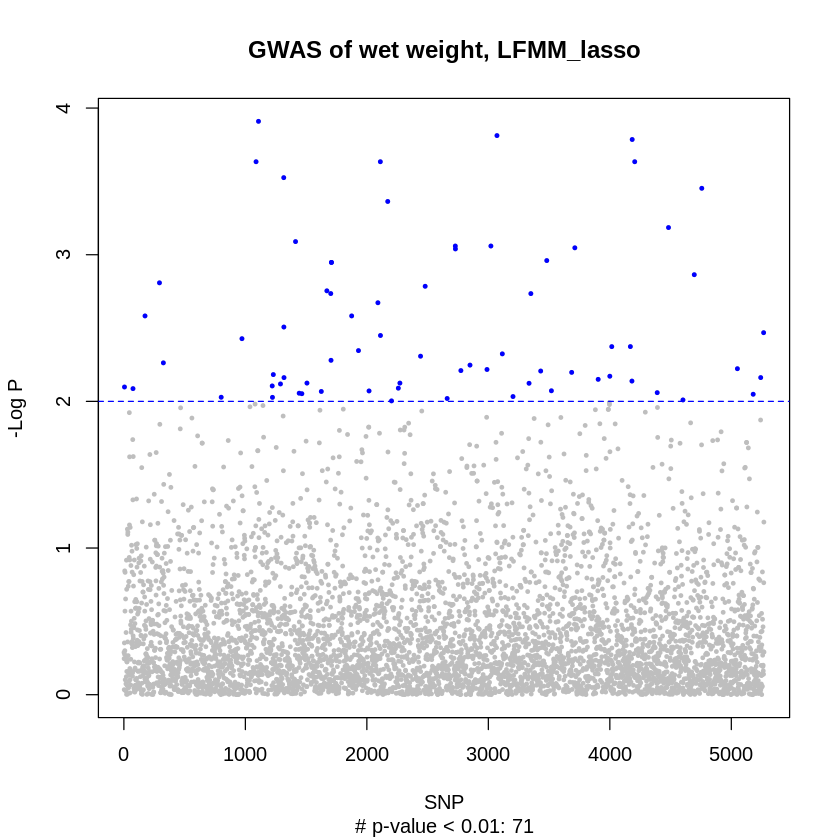

In [268]:
## Manhattan plot
xL <- 1:length(pvalues_lW)

plot(-log10(pvalues_lW), 
      pch = 19, 
      cex = .4, 
      xlab = "SNP", ylab = "-Log P",
      col = "grey")

abline(h=-log10(0.01), col="blue", lty="dashed")
keep <- pvalues_lW < 0.01
keep[which(is.na(keep))] <- FALSE
lassoP01W <- xL[keep]
title("GWAS of wet weight, LFMM_lasso",
      sub=paste0("# p-value < 0.01: ",as.character(length(lassoP01W))))
points(lassoP01W,-log10(pvalues_lW[keep]), pch=19,cex=.4,col="blue")


In [172]:
write.table(pvalues_l,"GWAS_weight_lfmmLasso.pvalues",row.names = T, col.names = T)

In [269]:
#SNPs identified by both methods 
both = intersect(rownames(pvalues_lW)[lassoP01W],rownames(pvalues_rW)[ridgeP01W])
write.table(both,"GWAS_weight_lfmmBothP01.pvalues",row.names = T, col.names = T)
length(both)
both

[1] 37

[1] "Contig793_22793"    "Contig1752_7704"    "Contig20301_25778" 
 [4] "Contig20556_1169"   "Contig23953_13742"  "Contig25187_18688" 
 [7] "Contig25896_4769"   "Contig26307_31575"  "Contig28951_24454" 
[10] "Contig29300_18485"  "Contig29459_8886"   "Contig29459_8891"  
[13] "Contig32428_12580"  "Contig36326_22771"  "Contig37341_12397" 
[16] "Contig43024_5264"   "Contig47156_8140"   "Contig47156_8144"  
[19] "Contig47842_5739"   "Contig52538_1318"   "Contig53370_3575"  
[22] "Contig54957_15652"  "Contig58145_4399"   "Contig61234_248"   
[25] "Contig61792_3239"   "Contig65054_11649"  "Contig65681_10897" 
[28] "Contig72135_1462"   "Contig82836_6883"   "Contig91596_1157"  
[31] "Contig92189_38401"  "Contig93748_2190"   "Contig103892_1489" 
[34] "Contig109827_6152"  "Contig120378_211"   "Contig130869_2254" 
[37] "Contig135601_12809"

In [270]:
#SNPs identified by at least 1 methods 
unW = union(rownames(pvalues_lW)[lassoP01W],rownames(pvalues_rW)[ridgeP01W])
#write.table(unW,"GWAS_weight_lfmmUnionP01.pvalues",row.names = T, col.names = T)
length(unW)

[1] 83

In [273]:
# Both length and width
unall <- intersect(un,unW)
write.table(unall,"GWAS_UnionWeightWidth_lfmmP01.pvalues",row.names = T, col.names = T)
length(unall)

[1] 44